In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# 1. DATA LOADING AND INITIALIZATION
oad the preprocessed dataset and examine its structure to understand the feature space and prepare for clustering analysis.

In [3]:
df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Personal/human_activity_segmentation_project/data/processed/model_ready.csv')

In [ ]:
df.head()

,subject,timestamp,activityID,heart_rate,hand_temp,hand_acc_x16,hand_acc_y16,hand_acc_z16,hand_gyro_x,hand_gyro_y,...,ankle_temp,ankle_acc_x16,ankle_acc_y16,ankle_acc_z16,ankle_gyro_x,ankle_gyro_y,ankle_gyro_z,ankle_mag_x,ankle_mag_y,ankle_mag_z
0,subject101,37.66,1,100.0,30.375,2.21530,8.27915,5.58753,-0.004750,0.037579,...,30.75,9.73855,-1.84761,0.095156,0.002908,-0.027714,0.001752,-61.1081,-36.8636,-58.3696
1,subject101,37.67,1,100.0,30.375,2.29196,7.67288,5.74467,-0.171710,0.025479,...,30.75,9.69762,-1.88438,-0.020804,0.020882,0.000945,0.006007,-60.8916,-36.3197,-58.3656
2,subject101,37.68,1,100.0,30.375,2.29090,7.14240,5.82342,-0.238241,0.011214,...,30.75,9.69633,-1.92203,-0.059173,-0.035392,-0.052422,-0.004882,-60.3407,-35.7842,-58.6119
3,subject101,37.69,1,100.0,30.375,2.21800,7.14365,5.89930,-0.192912,0.019053,...,30.75,9.66370,-1.84714,0.094385,-0.032514,-0.018844,0.026950,-60.7646,-37.1028,-57.8799
4,subject101,37.70,1,100.0,30.375,2.30106,7.25857,6.09259,-0.069961,-0.018328,...,30.75,9.77578,-1.88582,0.095775,0.001351,-0.048878,-0.006328,-60.2040,-37.1225,-57.8847


In [ ]:
df.shape

(2724953, 34)

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2724953 entries, 0 to 2724952
Data columns (total 34 columns):
 #   Column         Dtype  
---  ------         -----  
 0   subject        object 
 1   timestamp      float64
 2   activityID     int64  
 3   heart_rate     float64
 4   hand_temp      float64
 5   hand_acc_x16   float64
 6   hand_acc_y16   float64
 7   hand_acc_z16   float64
 8   hand_gyro_x    float64
 9   hand_gyro_y    float64
 10  hand_gyro_z    float64
 11  hand_mag_x     float64
 12  hand_mag_y     float64
 13  hand_mag_z     float64
 14  chest_temp     float64
 15  chest_acc_x16  float64
 16  chest_acc_y16  float64
 17  chest_acc_z16  float64
 18  chest_gyro_x   float64
 19  chest_gyro_y   float64
 20  chest_gyro_z   float64
 21  chest_mag_x    float64
 22  chest_mag_y    float64
 23  chest_mag_z    float64
 24  ankle_temp     float64
 25  ankle_acc_x16  float64
 26  ankle_acc_y16  float64
 27  ankle_acc_z16  float64
 28  ankle_gyro_x   float64
 29  ankle_gyro_y  

# 2. TIME WINDOW CREATION
Convert continuous sensor data into fixed-length time windows (250 samples = 2.5 seconds) with 50% overlap (125 samples) to capture temporal patterns while maintaining sufficient samples for clustering.

In [ ]:
def create_windows(df, subject_col, activity_col, window_size=250, step=125):


    windows = []
    labels = []
    subjects = []
    meta = []

    grouped = df.groupby([subject_col, activity_col])

    for (sub, act), group_df in grouped:

        group_df = group_df.drop(['subject', 'activityID'], axis=1).reset_index(drop=True)

        start = 0
        while start + window_size <= len(group_df):
            window = group_df.iloc[start:start + window_size]


            windows.append(window.values)

            labels.append(act)
            subjects.append(sub)

            meta.append({
                "subject": sub,
                "activity": act,
                "start_index": start,
                "end_index": start + window_size
            })

            start += step

    return np.array(windows), np.array(labels), np.array(subjects), meta


In [ ]:
windows, labels, subjects, meta = create_windows(
    df=df,
    subject_col="subject",
    activity_col="activityID",
    window_size=250,
    step=125
)

In [ ]:
windows[0]

array([[ 37.66  , 100.    ,  30.375 , ..., -61.1081, -36.8636, -58.3696],
       [ 37.67  , 100.    ,  30.375 , ..., -60.8916, -36.3197, -58.3656],
       [ 37.68  , 100.    ,  30.375 , ..., -60.3407, -35.7842, -58.6119],
       ...,
       [ 40.13  , 102.    ,  30.4375, ..., -57.3399, -42.4971, -59.5745],
       [ 40.14  , 102.    ,  30.4375, ..., -57.1234, -41.9531, -59.5705],
       [ 40.15  , 102.    ,  30.4375, ..., -57.8029, -41.1635, -59.0614]])

In [ ]:
windows.shape

(21642, 250, 32)

In [ ]:
labels

array([ 1,  1,  1, ..., 24, 24, 24])

In [ ]:
subjects

array(['subject101', 'subject101', 'subject101', ..., 'subject109',
       'subject109', 'subject109'], dtype='<U10')

In [ ]:
meta[0]

{'subject': 'subject101',
 'activity': np.int64(1),
 'start_index': 0,
 'end_index': 250}

# 3. FEATURE STANDARDIZATION
Apply StandardScaler to normalize all features, ensuring equal contribution from different sensor types (acceleration, gyroscope, magnetometer, heart rate) regardless of their original measurement scales.

In [ ]:
from sklearn.preprocessing import StandardScaler


num_windows, win_len, num_features = windows.shape
X_flat = windows.reshape(num_windows, win_len * num_features)

scaler = StandardScaler()
X_flat_scaled = scaler.fit_transform(X_flat)


X_scaled = X_flat_scaled.reshape(num_windows, win_len, num_features)


In [ ]:
X_scaled.shape

(21642, 250, 32)

# 4. OPTIMAL CLUSTER DETERMINATION
## 4.1 Elbow Method
Test K-Means with k values from 8 to 20 to identify the "elbow point" where inertia reduction slows down, indicating diminishing returns from additional clusters.

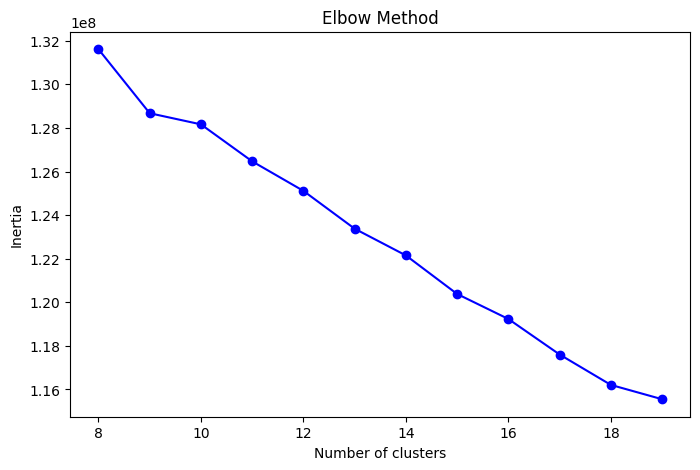

In [ ]:
from sklearn.cluster import KMeans

inertia = []
K = range(8, 20)

for k in K:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(X_flat_scaled)
    inertia.append(kmeans.inertia_)

plt.figure(figsize=(8,5))
plt.plot(K, inertia, 'bo-')
plt.xlabel('Number of clusters')
plt.ylabel('Inertia')
plt.title('Elbow Method')
plt.show()

## 4.2 Silhouette Analysis
Calculate silhouette scores for each k value to measure cluster separation quality, with higher scores indicating better-defined clusters.

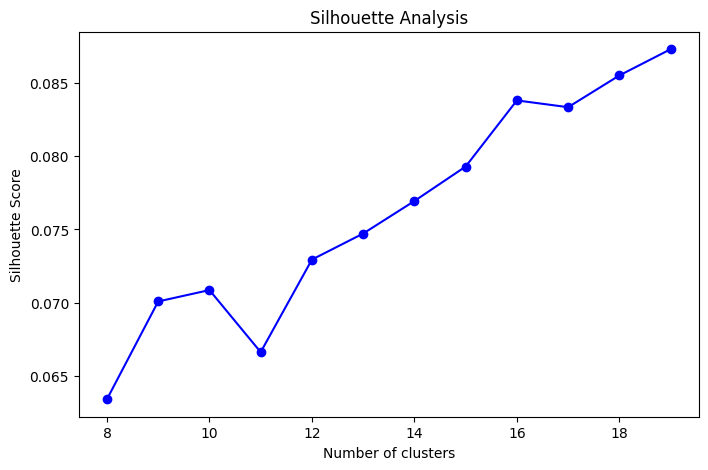

In [ ]:
from sklearn.metrics import silhouette_score

sil_scores = []

for k in K:
    kmeans = KMeans(n_clusters=k, random_state=42)
    labels = kmeans.fit_predict(X_flat_scaled)
    score = silhouette_score(X_flat_scaled, labels)
    sil_scores.append(score)

plt.figure(figsize=(8,5))
plt.plot(K, sil_scores, 'bo-')
plt.xlabel('Number of clusters')
plt.ylabel('Silhouette Score')
plt.title('Silhouette Analysis')
plt.show()

# 5. HIERARCHICAL CLUSTERING
Apply agglomerative hierarchical clustering using Ward's linkage method to discover natural activity hierarchies and validate the number of clusters suggested by K-Means.

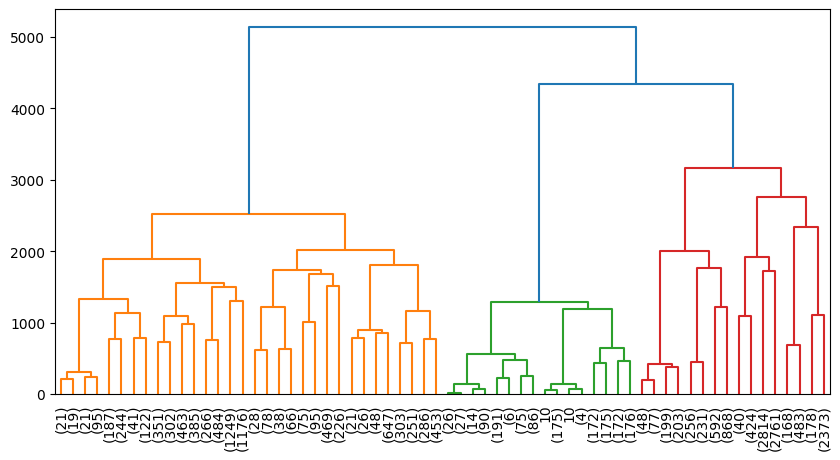

In [ ]:
from scipy.cluster.hierarchy import linkage, dendrogram, fcluster

Z = linkage(X_flat_scaled, method='ward')
plt.figure(figsize=(10,5))
dendrogram(Z,labels=labels, leaf_rotation=90, leaf_font_size=10, truncate_mode='level', p=5)
plt.show()

optimal_k = 18

labels_hier = fcluster(Z, t=optimal_k, criterion='maxclust')

# 6. DBSCAN CLUSTERING
## 6.1 Initial DBSCAN Implementation
Apply density-based clustering with ε=5 and min_samples=10 to identify density-based groups and detect noise/outliers in the data.

In [ ]:
from sklearn.cluster import DBSCAN

dbscan = DBSCAN(eps=5, min_samples=10)
labels_db = dbscan.fit_predict(X_flat_scaled)

## 6.2 DBSCAN Results Analysis
Evaluate DBSCAN performance by calculating cluster counts, noise percentage, and internal validation metrics (silhouette score, Davies-Bouldin index).

In [ ]:
unique_labels = np.unique(labels_db)
n_clusters = len(unique_labels) - (1 if -1 in labels_db else 0)
n_noise = np.sum(labels_db == -1)

print(f"Number of clusters found: {n_clusters}")
print(f"Number of noise points: {n_noise} ({n_noise/len(labels_db)*100:.1f}%)")
print(f"Unique labels: {unique_labels}")


print("\nCluster sizes:")
for label in unique_labels:
    if label == -1:
        print(f"  Noise: {np.sum(labels_db == label)} samples")
    else:
        print(f"  Cluster {label}: {np.sum(labels_db == label)} samples")


if n_clusters >= 2:

    non_noise_mask = labels_db != -1
    if np.sum(non_noise_mask) > 0:
        filtered_labels = labels_db[non_noise_mask]
        filtered_features = X_flat_scaled[non_noise_mask]

        silhouette = silhouette_score(filtered_features, filtered_labels)
        db_score = davies_bouldin_score(filtered_features, filtered_labels)

        print(f"\nDBSCAN Evaluation (excluding noise):")
        print(f"Silhouette Score: {silhouette:.3f}")
        print(f"Davies-Bouldin Score: {db_score:.3f}")
    else:
        print("\nAll points classified as noise!")
else:
    print("\nDBSCAN found 0 or 1 clusters - cannot evaluate metrics")

plt.figure(figsize=(10, 8))
scatter = plt.scatter(X_pca[:, 0], X_pca[:, 1],
                     c=labels_db, cmap='tab20', alpha=0.7)
plt.title(f'DBSCAN Clustering (eps=5, min_samples=10)\nClusters: {n_clusters}, Noise: {n_noise}')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.colorbar(scatter, label='Cluster ID (Noise = -1)')
plt.show()

if n_clusters >= 2:
    print("\nDBSCAN Cluster Composition (excluding noise):")
    for label in unique_labels:
        if label != -1:
            mask = labels_db == label
            activities_in_cluster = labels[mask]
            unique_activities = np.unique(activities_in_cluster)

            print(f"\nCluster {label} (size: {mask.sum()}):")
            print(f"  Contains activities: {unique_activities}")


            activity_counts = pd.Series(activities_in_cluster).value_counts()
            for i, (act_id, count) in enumerate(activity_counts.head(3).items()):
                percentage = (count / mask.sum()) * 100
                print(f"  {i+1}. Activity {act_id}: {count} samples ({percentage:.1f}%)")

DBSCAN Clustering Results:
Number of clusters found: 92
Number of noise points: 18183 (84.0%)
Unique labels: [-1  0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22
 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46
 47 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70
 71 72 73 74 75 76 77 78 79 80 81 82 83 84 85 86 87 88 89 90 91]

Cluster sizes:
  Noise: 18183 samples
  Cluster 0: 37 samples
  Cluster 1: 30 samples
  Cluster 2: 27 samples
  Cluster 3: 68 samples
  Cluster 4: 14 samples
  Cluster 5: 36 samples
  Cluster 6: 30 samples
  Cluster 7: 13 samples
  Cluster 8: 21 samples
  Cluster 9: 10 samples
  Cluster 10: 64 samples
  Cluster 11: 25 samples
  Cluster 12: 130 samples
  Cluster 13: 100 samples
  Cluster 14: 101 samples
  Cluster 15: 42 samples
  Cluster 16: 54 samples
  Cluster 17: 141 samples
  Cluster 18: 51 samples
  Cluster 19: 63 samples
  Cluster 20: 12 samples
  Cluster 21: 10 samples
  Cluster 22: 51 samples

NameError: name 'davies_bouldin_score' is not defined

## 6.3 DBSCAN Parameter Sensitivity
Conduct comprehensive parameter tuning across different ε (2-10) and min_samples (5-25) values to understand algorithm sensitivity and identify optimal parameter combinations.

In [ ]:
param_grid = [
    {'eps': 3, 'min_samples': 5},
    {'eps': 5, 'min_samples': 10},
    {'eps': 7, 'min_samples': 15},
    {'eps': 10, 'min_samples': 20}
]

for params in param_grid:
    dbscan = DBSCAN(eps=params['eps'], min_samples=params['min_samples'])
    labels = dbscan.fit_predict(X_flat_scaled)
    n_clusters = len(np.unique(labels)) - (1 if -1 in labels else 0)
    n_noise = np.sum(labels == -1)

    print(f"eps={params['eps']}, min_samples={params['min_samples']}: "
          f"Clusters={n_clusters}, Noise={n_noise} ({(n_noise/len(labels)*100):.1f}%)")

eps=3, min_samples=5: Clusters=37, Noise=21221 (98.1%)
eps=5, min_samples=10: Clusters=92, Noise=18183 (84.0%)
eps=7, min_samples=15: Clusters=75, Noise=17371 (80.3%)
eps=10, min_samples=20: Clusters=66, Noise=16570 (76.6%)


# 7. FINAL K-MEANS CLUSTERING
Based on validation results, select optimal k=18 (matching the 18 activity types) and perform final K-Means clustering for activity segmentation.

In [ ]:
eps_values = [2, 3, 4, 5, 6, 7, 8, 9, 10]
min_samples_values = [5, 10, 15, 20, 25]


n_clusters_matrix = np.zeros((len(eps_values), len(min_samples_values)))
noise_matrix = np.zeros((len(eps_values), len(min_samples_values)))

for i, eps in enumerate(eps_values):
    for j, min_samples in enumerate(min_samples_values):
        dbscan = DBSCAN(eps=eps, min_samples=min_samples)
        labels = dbscan.fit_predict(X_flat_scaled)

        n_clusters = len(np.unique(labels)) - (1 if -1 in labels else 0)
        n_noise = np.sum(labels == -1)

        n_clusters_matrix[i, j] = n_clusters
        noise_matrix[i, j] = n_noise / len(labels) * 100


fig, axes = plt.subplots(1, 2, figsize=(14, 5))


im1 = axes[0].imshow(n_clusters_matrix, cmap='viridis', aspect='auto')
axes[0].set_title('Number of Clusters Found', fontsize=14)
axes[0].set_xlabel('min_samples')
axes[0].set_ylabel('eps')
axes[0].set_xticks(range(len(min_samples_values)))
axes[0].set_yticks(range(len(eps_values)))
axes[0].set_xticklabels(min_samples_values)
axes[0].set_yticklabels(eps_values)
plt.colorbar(im1, ax=axes[0], label='Number of Clusters')


for i in range(len(eps_values)):
    for j in range(len(min_samples_values)):
        axes[0].text(j, i, f'{int(n_clusters_matrix[i, j])}',
                    ha='center', va='center', color='white', fontweight='bold')


im2 = axes[1].imshow(noise_matrix, cmap='Reds', aspect='auto')
axes[1].set_title('Noise Percentage (%)', fontsize=14)
axes[1].set_xlabel('min_samples')
axes[1].set_ylabel('eps')
axes[1].set_xticks(range(len(min_samples_values)))
axes[1].set_yticks(range(len(eps_values)))
axes[1].set_xticklabels(min_samples_values)
axes[1].set_yticklabels(eps_values)
plt.colorbar(im2, ax=axes[1], label='Noise %')


for i in range(len(eps_values)):
    for j in range(len(min_samples_values)):
        axes[1].text(j, i, f'{noise_matrix[i, j]:.1f}',
                    ha='center', va='center', color='white', fontweight='bold')

plt.suptitle('DBSCAN Parameter Sensitivity Analysis', fontsize=16, fontweight='bold', y=1.05)
plt.tight_layout()
plt.savefig('figures/dbscan_parameter_heatmap.png', dpi=300, bbox_inches='tight')
plt.show()

# 8. CLUSTER PROFILING
Create detailed profiles for each cluster including size, dominant activity, activity purity, diversity metrics, and subject distribution to interpret the discovered segments.

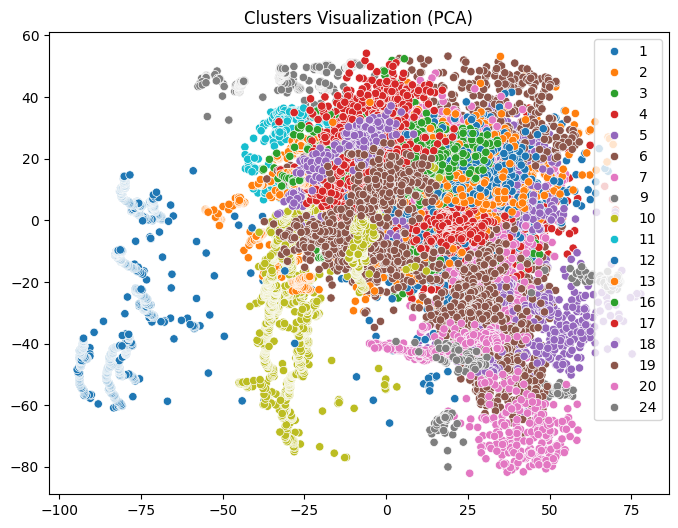

In [ ]:
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_flat_scaled)

plt.figure(figsize=(8,6))
sns.scatterplot(x=X_pca[:,0], y=X_pca[:,1], hue=labels, palette='tab10')
plt.title('Clusters Visualization (PCA)')
plt.show()


# 9. CLUSTER VISUALIZATION
Apply PCA to reduce high-dimensional feature space to 2D for visualization, plot cluster assignments with centers marked, and analyze spatial distribution of activity segments.

Final K-Means with k=18

Cluster Statistics:
Total samples: 21642
Number of clusters: 18
Average cluster size: 1202
Cluster size range: 212 to 3781
Cluster size std: 922.4

Cluster Profiles:
    cluster_id  size  dominant_activity  activity_purity  activity_diversity
0            0  1198                  6        92.821369                   5
1            1   536                 10        91.977612                   4
2            2  2001                 10        70.964518                   7
3            3   839                  4        54.946365                   7
4            4  1394                  1       100.000000                   1
5            5  2895                 17        54.784111                  15
6            6   212                  5        92.452830                   3
7            7   675                  9        96.592593                   3
8            8  1361                 12        20.940485                  14
9            9  1875                  4

FileNotFoundError: [Errno 2] No such file or directory: 'figures/cluster_visualization_2d.png'

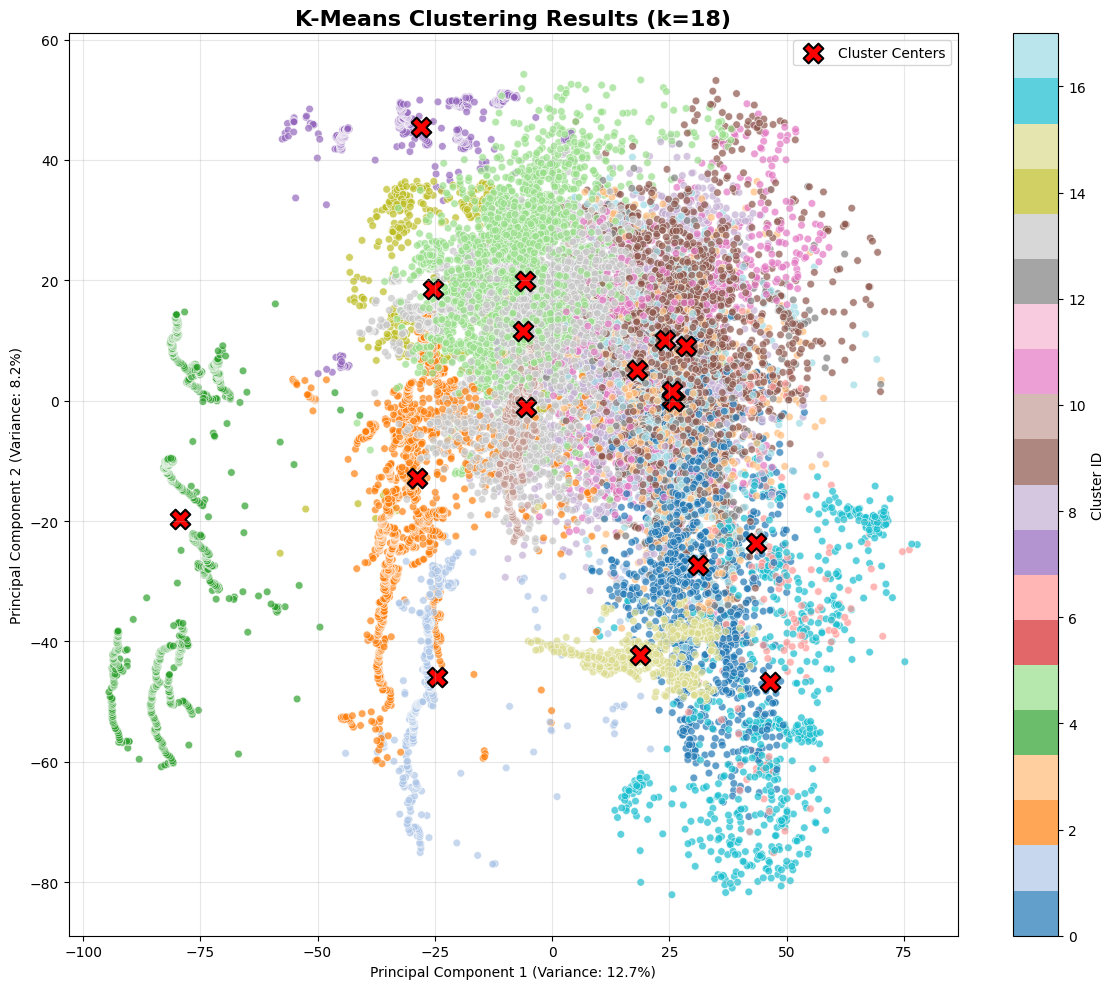

In [ ]:
optimal_k = 18
kmeans_final = KMeans(n_clusters=optimal_k, random_state=42, n_init=10)
kmeans_labels = kmeans_final.fit_predict(X_flat_scaled)

print(f"Final K-Means with k={optimal_k}")
print("=" * 50)


cluster_sizes = pd.Series(kmeans_labels).value_counts().sort_index()
print("\nCluster Statistics:")
print(f"Total samples: {len(kmeans_labels)}")
print(f"Number of clusters: {optimal_k}")
print(f"Average cluster size: {len(kmeans_labels)/optimal_k:.0f}")
print(f"Cluster size range: {cluster_sizes.min()} to {cluster_sizes.max()}")
print(f"Cluster size std: {cluster_sizes.std():.1f}")



def create_cluster_profile(cluster_labels, true_labels, subjects, X_features):
    """Create comprehensive cluster profiles"""

    profiles = []
    for cluster_id in range(optimal_k):
        mask = cluster_labels == cluster_id


        activities = true_labels[mask]
        activity_counts = pd.Series(activities).value_counts()


        subject_counts = pd.Series(subjects[mask]).value_counts()


        cluster_features = X_features[mask]

        profile = {
            'cluster_id': cluster_id,
            'size': mask.sum(),
            'size_percentage': (mask.sum() / len(cluster_labels)) * 100,


            'dominant_activity': activity_counts.index[0] if len(activity_counts) > 0 else -1,
            'dominant_activity_percentage': (activity_counts.iloc[0] / mask.sum() * 100) if len(activity_counts) > 0 else 0,
            'activity_diversity': len(activity_counts),
            'activity_purity': (activity_counts.iloc[0] / mask.sum() * 100) if len(activity_counts) > 0 else 0,


            'subject_diversity': len(subject_counts),
            'dominant_subject': subject_counts.index[0] if len(subject_counts) > 0 else None,


            'avg_acceleration': cluster_features[:, :3].mean(),
            'avg_heart_rate': cluster_features[:, -1].mean() if X_features.shape[1] > 0 else 0
        }


        for i, (act_id, count) in enumerate(activity_counts.head(3).items()):
            profile[f'top_activity_{i+1}'] = act_id
            profile[f'top_activity_{i+1}_percentage'] = count / mask.sum() * 100

        profiles.append(profile)

    return pd.DataFrame(profiles)


cluster_profiles = create_cluster_profile(kmeans_labels, labels, subjects, X_flat_scaled)
print("\nCluster Profiles:")
print(cluster_profiles[['cluster_id', 'size', 'dominant_activity',
                        'activity_purity', 'activity_diversity']])


plt.figure(figsize=(12, 10))
scatter = plt.scatter(X_pca[:, 0], X_pca[:, 1],
                     c=kmeans_labels, cmap='tab20',
                     alpha=0.7, s=30, edgecolors='w', linewidth=0.5)


centers_pca = pca.transform(kmeans_final.cluster_centers_)
plt.scatter(centers_pca[:, 0], centers_pca[:, 1],
           c='red', marker='X', s=200, label='Cluster Centers',
           edgecolors='black', linewidth=1.5)

plt.title(f'K-Means Clustering Results (k={optimal_k})', fontsize=16, fontweight='bold')
plt.xlabel('Principal Component 1 (Variance: {:.1f}%)'.format(pca.explained_variance_ratio_[0]*100))
plt.ylabel('Principal Component 2 (Variance: {:.1f}%)'.format(pca.explained_variance_ratio_[1]*100))
plt.colorbar(scatter, label='Cluster ID')
plt.grid(True, alpha=0.3)
plt.legend()
plt.tight_layout()
plt.show()